In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

import sys
sys.path.append('../../scripts')

from btsc_dataset import load_full_dataset, split_images_and_labels, resize_images
from utils import train_validation_test_split

import numpy as np

In [2]:
resized_data = resize_images(load_full_dataset(), size=32)
(images, labels) = split_images_and_labels(resized_data)
unique_labels = set(labels)

print('Images:', images.shape)
print('Labels:', labels.shape)
print('Total Unique Labels:', len(unique_labels))

Images: (7095, 32, 32, 3)
Labels: (7095,)
Total Unique Labels: 62


In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

integer_labels= LabelEncoder().fit_transform(labels)
ont_hot_labels = to_categorical(integer_labels)

X = images
y = ont_hot_labels

X_train, X_valid, X_test, \
y_train, y_valid, y_test = train_validation_test_split(X, y, random_state=42)

print('X:', X.shape)
print('y:', y.shape)
print()
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print()
print('X_valid:', X_valid.shape)
print('y_valid:', y_valid.shape)
print()
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

Using TensorFlow backend.


X: (7095, 32, 32, 3)
y: (7095, 62)

X_train: (4257, 32, 32, 3)
y_train: (4257, 62)

X_valid: (1419, 32, 32, 3)
y_valid: (1419, 62)

X_test: (1419, 32, 32, 3)
y_test: (1419, 62)


In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

datagen.fit(X_train)

In [5]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.applications import *

vgg_model = VGG19(
  weights='imagenet',
  include_top=False,
  input_shape=X[0].shape,
)

layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

x = layer_dict['block2_pool'].output

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(len(unique_labels), activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=x)

for layer in model.layers[0:7]:
    layer.trainable = False

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=0, 
    mode='min',
)
model_checkpoint = ModelCheckpoint(
    'vgg19_augmentation_weights.hdf5', 
    save_best_only=True, 
    monitor='val_loss', 
    mode='min',
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=7, 
    verbose=1, 
    min_delta=1e-4, 
    mode='min',
)

history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=50),
    validation_data=(X_valid, y_valid), 
    steps_per_epoch=len(X_train) / 50,
    epochs=50, 
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr_loss], 
)

model.load_weights('vgg19_augmentation_weights.hdf5')

Epoch 1/50
86/85 [==============================] - 23s 273ms/step - loss: 5.7384 - acc: 0.1545 - val_loss: 2.9874 - val_acc: 0.3206
Epoch 2/50
86/85 [==============================] - 22s 258ms/step - loss: 2.5620 - acc: 0.3899 - val_loss: 2.2422 - val_acc: 0.4729
Epoch 3/50
86/85 [==============================] - 23s 271ms/step - loss: 1.9728 - acc: 0.5047 - val_loss: 1.7198 - val_acc: 0.5786
Epoch 4/50
86/85 [==============================] - 22s 259ms/step - loss: 1.6715 - acc: 0.5545 - val_loss: 1.6061 - val_acc: 0.6237
Epoch 5/50
86/85 [==============================] - 22s 257ms/step - loss: 1.3598 - acc: 0.6238 - val_loss: 1.3806 - val_acc: 0.6547
Epoch 6/50
86/85 [==============================] - 23s 263ms/step - loss: 1.1577 - acc: 0.6695 - val_loss: 1.2476 - val_acc: 0.6927
Epoch 7/50
86/85 [==============================] - 23s 270ms/step - loss: 0.9962 - acc: 0.7136 - val_loss: 1.2220 - val_acc: 0.6843
Epoch 8/50
86/85 [==============================] - 22s 253ms/step - 

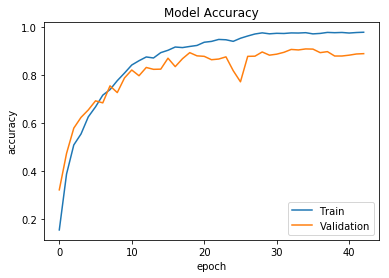

In [7]:
# Plot training & validation accuracies per epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

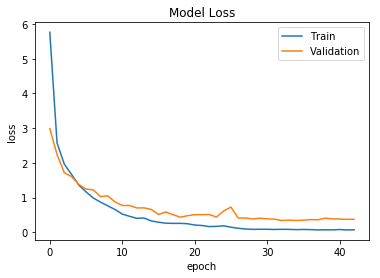

In [8]:
# Plot training & validation losses per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [10]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)

print('Test Results:')
print('  Loss     =', loss)
print('  Accuracy =', acc)

1419/1419 [==============================] - 4s 3ms/step
Test Results:
  Loss     = 0.3555592783241729
  Accuracy = 0.9069767443960699
